## Q1.1 — Model choice and justification

**Chosen model:** Linear Regression (OLS)

**Why this model?**  
Cook’s Distance is an influence diagnostic originally derived for ordinary least squares (OLS).
Using OLS keeps Cook’s Distance interpretation standard and directly tied to leverage and residuals.

**Chosen library:** Statsmodels OLS

**Why this library?**  
Statsmodels provides built-in influence diagnostics via `get_influence()`, including Cook’s Distance,
so we can compute it accurately without implementing custom matrix formulas.
This reduces implementation errors and provides a clean, transparent workflow.



In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv("usina_with_outliers.csv")

TARGET = "PE"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Statsmodels requires an explicit intercept column
X_sm = sm.add_constant(X)

ols_model = sm.OLS(y, X_sm).fit()


In [6]:
# 1) Cook's Distance for each observation
influence = ols_model.get_influence()
cooks_d, pvals = influence.cooks_distance

# 2) Choose threshold rule
n = len(df)
threshold = 4 / n  # standard rule of thumb

print(f"n = {n}")
print(f"Cook's D threshold (4/n) = {threshold:.6f}")
print(f"Max Cook's D = {cooks_d.max():.6f}")

n = 9568
Cook's D threshold (4/n) = 0.000418
Max Cook's D = 1.283760


In [7]:
outlier_mask = cooks_d > threshold
outlier_idx = np.where(outlier_mask)[0]

print("Number of outliers flagged:", outlier_mask.sum())
print("First 20 outlier indices:", outlier_idx[:20])



Number of outliers flagged: 120
First 20 outlier indices: [  35   49  112  339  402  418  511  526  606  875  927 1091 1130 1247
 1290 1348 1475 1524 1662 1735]


In [8]:
df_clean = df.loc[~outlier_mask].copy().reset_index(drop=True)

print("Original shape:", df.shape)
print("Cleaned shape :", df_clean.shape)

# Export EXACT filename required
df_clean.to_csv("usina.csv", index=False)
print("Saved cleaned dataset as usina.csv")


Original shape: (9568, 5)
Cleaned shape : (9448, 5)
Saved cleaned dataset as usina.csv


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

LAMBDAS = [0.01, 0.1, 1, 10, 100]
TARGET = "PE"

def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    return {
        "Train MSE": mean_squared_error(y_train, pred_train),
        "Train MAE": mean_absolute_error(y_train, pred_train),
        "Train R2":  r2_score(y_train, pred_train),
        "Test MSE":  mean_squared_error(y_test, pred_test),
        "Test MAE":  mean_absolute_error(y_test, pred_test),
        "Test R2":   r2_score(y_test, pred_test),
    }

def run_q2_models(df, dataset_name):
    X = df.drop(columns=[TARGET])
    y = df[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, shuffle=True
    )

    rows = []

    m = eval_model(LinearRegression(), X_train, y_train, X_test, y_test)
    rows.append({"Dataset": dataset_name, "Model": "Linear Regression", "lambda": None, **m})

    for lam in LAMBDAS:
        m = eval_model(Ridge(alpha=lam), X_train, y_train, X_test, y_test)
        rows.append({"Dataset": dataset_name, "Model": f"Ridge (λ={lam})", "lambda": lam, **m})

    for lam in LAMBDAS:
        m = eval_model(Lasso(alpha=lam, max_iter=200000, random_state=42), X_train, y_train, X_test, y_test)
        rows.append({"Dataset": dataset_name, "Model": f"Lasso (λ={lam})", "lambda": lam, **m})

    return pd.DataFrame(rows)

df_out = pd.read_csv("usina_with_outliers.csv")
df_clean = pd.read_csv("usina.csv")

results_q2 = pd.concat([
    run_q2_models(df_out, "with_outliers"),
    run_q2_models(df_clean, "cleaned"),
], ignore_index=True)

results_q2


,Dataset,Model,lambda,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,with_outliers,Linear Regression,NaN,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,with_outliers,Ridge (λ=0.01),0.01,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,with_outliers,Ridge (λ=0.1),0.10,123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
3,with_outliers,Ridge (λ=1),1.00,123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
4,with_outliers,Ridge (λ=10),10.00,123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
5,with_outliers,Ridge (λ=100),100.00,123.384213,5.199261,0.650171,125.116548,5.053003,0.642565
6,with_outliers,Lasso (λ=0.01),0.01,123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
7,with_outliers,Lasso (λ=0.1),0.10,123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,with_outliers,Lasso (λ=1),1.00,123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
9,with_outliers,Lasso (λ=10),10.00,126.141514,5.540418,0.642353,128.902136,5.408803,0.631750


**Discussion**

**Do outliers change train error? Test error?**

Yes—with outliers, both train and test errors are much larger. Train MSE ≈ 123, Test MSE ≈ 125, Test R² ≈ 0.64. After removing outliers, both train and test errors drop a lot. Train MSE ≈ 19.86, Test MSE ≈ 20.40, Test R² ≈ 0.93, showing outliers substantially hurt fit and prediction.


**Which dataset (with outliers vs without outliers) shows better generalization?**

The outlier-removed dataset generalizes better, because test error is far lower and test R² is much higher. Train and test metrics are also closer, indicating more stable generalization.


**Do Ridge/Lasso appear to help relative to standard linear regression?**

For small to moderate λ, Ridge is essentially identical to Linear Regression on both datasets, so it doesn’t provide noticeable improvement here. Lasso also matches closely for small λ, but as λ grows, it underfits and performance worsens, especially at λ=100.


## Q3.1 — Method choice and scaling decision

**Dataset used:** `usina.csv` (outliers removed), as required.

### Chosen model: Linear Regression (OLS)
**Why this model?**  
Coefficient “reliability” is most naturally assessed using classical inference quantities such as
standard errors and t-statistics, which are defined in the ordinary least squares (OLS) framework.
Using OLS allows a direct, standard interpretation of coefficient uncertainty: a coefficient is more
reliable when its estimated effect is large relative to its standard error (large |t|).

### Chosen library: Statsmodels OLS
**Why this library?**  
Statsmodels provides built-in access to coefficient estimates, standard errors, and t-statistics
(`.params`, `.bse`, `.tvalues`) in a transparent way. Scikit-learn focuses on prediction and does not
directly provide standard errors / t-values for coefficient reliability.

### Scaling decision (IVs and/or DV)
**Would I scale?**  
For this reliability task, I would **scale the independent variables (IVs)** (standardize features),
and **not scale the dependent variable (DV)**.

**Justification:**  
Reliability comparisons across coefficients can be distorted when predictors are in very different
units (e.g., degrees vs pressure). Standardizing IVs puts predictors on the same scale, so coefficient
magnitudes and associated standard errors / t-values reflect relative signal rather than unit choice.
Scaling the DV is not necessary for reliability ranking because it scales both the coefficient and its
standard error by the same factor, leaving t-statistics essentially unchanged.


In [19]:
from sklearn.preprocessing import StandardScaler

# Load outlier-removed dataset (required)
df = pd.read_csv("usina.csv")

TARGET = "PE"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Scale IVs only (standardize predictors)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept and fit OLS
X_sm = sm.add_constant(X_scaled)
ols_scaled = sm.OLS(y, X_sm).fit()

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Keep feature names after scaling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Add intercept and fit OLS
X_sm = sm.add_constant(X_scaled_df)
ols_scaled = sm.OLS(y, X_sm).fit()

# Build table: coef, SE, t, |t|
summary_tbl = pd.DataFrame({
    "coef": ols_scaled.params,
    "std_err": ols_scaled.bse,
    "t": ols_scaled.tvalues
})
summary_tbl["abs_t"] = summary_tbl["t"].abs()

# Exclude intercept from the reliability ranking
coef_tbl = summary_tbl.drop(index="const")

# Sort by |t| descending for easy viewing
coef_tbl_sorted = coef_tbl.sort_values("abs_t", ascending=False)

coef_tbl_sorted

,coef,std_err,t,abs_t
AT,-14.556614,0.112743,-129.113036,129.113036
RH,-2.197120,0.059547,-36.897303,36.897303
V,-3.030737,0.091684,-33.056481,33.056481
AP,0.442513,0.056053,7.894540,7.894540


In [21]:
most_reliable = coef_tbl_sorted.index[0]
least_reliable = coef_tbl_sorted.index[-1]

print("Most reliable coefficient (largest |t|):", most_reliable)
print("  coef   =", coef_tbl_sorted.loc[most_reliable, "coef"])
print("  std_err=", coef_tbl_sorted.loc[most_reliable, "std_err"])
print("  t      =", coef_tbl_sorted.loc[most_reliable, "t"])
print("  |t|    =", coef_tbl_sorted.loc[most_reliable, "abs_t"])
print()

print("Least reliable coefficient (smallest |t|):", least_reliable)
print("  coef   =", coef_tbl_sorted.loc[least_reliable, "coef"])
print("  std_err=", coef_tbl_sorted.loc[least_reliable, "std_err"])
print("  t      =", coef_tbl_sorted.loc[least_reliable, "t"])
print("  |t|    =", coef_tbl_sorted.loc[least_reliable, "abs_t"])


Most reliable coefficient (largest |t|): AT
  coef   = -14.55661357541881
  std_err= 0.11274317441142645
  t      = -129.11303634487257
  |t|    = 129.11303634487257

Least reliable coefficient (smallest |t|): AP
  coef   = 0.4425126711552607
  std_err= 0.056052999688007484
  t      = 7.894540410295582
  |t|    = 7.894540410295582


### Reasoning (coefficient reliability)
I measure coefficient reliability using the magnitude of the t-statistic:
\[
|t_j| = \left|\frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}\right|
\]
A larger |t| means the estimated effect is large relative to its uncertainty (more reliable).
A smaller |t| means the coefficient is weak relative to its standard error (less reliable).
I exclude the intercept from ranking because the question asks about feature coefficients.


## Q4.1 — Method choice and scaling decision (Feature Importance)

**Dataset used:** `usina.csv` (outliers removed), as required.

### Chosen model: Linear Regression (OLS)
**Why this model?**  
This task asks for “most important vs least important feature” for a regression model.
In a linear model, a common and interpretable notion of importance is the magnitude of a feature’s
(coefficient) effect on the prediction, holding other features fixed. OLS provides a direct coefficient
estimate for each feature, and with standardized predictors, coefficient magnitudes are comparable
across features.

### Chosen library: Statsmodels OLS
**Why this library?**  
Statsmodels provides transparent access to estimated coefficients (`.params`) and allows an explicit
intercept. It also makes it easy to report model details and coefficients clearly in a table.

### Scaling decision (IVs and/or DV)
**Would I scale?**  
For feature importance based on coefficient magnitude, I would **scale the independent variables (IVs)**
(standardize predictors) and **not scale the dependent variable (DV)**.

**Justification:**  
Without scaling, coefficient magnitudes are not directly comparable because each feature is measured
in different units (e.g., degrees vs pressure), so a large coefficient might simply reflect small units.
Standardizing IVs (mean 0, std 1) puts all predictors on the same scale, making \(|\beta|\) reflect the
change in prediction associated with a one-standard-deviation change in the feature.
Scaling the DV is not necessary for ranking importance because it scales all coefficients by the same
constant factor, which does not change their relative ordering.


In [22]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Fit OLS with intercept
X_sm = sm.add_constant(X_scaled_df)
ols_imp = sm.OLS(y, X_sm).fit()

# Extract standardized coefficients (exclude intercept)
beta = ols_imp.params.drop("const")
abs_beta = beta.abs().sort_values(ascending=False)

abs_beta

,0
AT,14.556614
V,3.030737
RH,2.197120
AP,0.442513


In [23]:
beta = ols_imp.params.drop("const")
importance_tbl = pd.DataFrame({
    "beta": beta,
    "abs_beta": beta.abs()
}).sort_values("abs_beta", ascending=False)

importance_tbl

,beta,abs_beta
AT,-14.556614,14.556614
V,-3.030737,3.030737
RH,-2.197120,2.197120
AP,0.442513,0.442513


In [24]:
most_important = importance_tbl.index[0]
least_important = importance_tbl.index[-1]

print("Most important feature (largest |standardized beta|):", most_important)
print("  beta    =", importance_tbl.loc[most_important, "beta"])
print("  |beta|  =", importance_tbl.loc[most_important, "abs_beta"])
print()

print("Least important feature (smallest |standardized beta|):", least_important)
print("  beta    =", importance_tbl.loc[least_important, "beta"])
print("  |beta|  =", importance_tbl.loc[least_important, "abs_beta"])

Most important feature (largest |standardized beta|): AT
  beta    = -14.55661357541881
  |beta|  = 14.55661357541881

Least important feature (smallest |standardized beta|): AP
  beta    = 0.4425126711552607
  |beta|  = 0.4425126711552607


### Reasoning (feature importance)
To compare feature importance in a linear regression, I standardize the predictors (IVs) so that each
feature has mean 0 and standard deviation 1. Then I use the magnitude of the standardized coefficient,
\(|\beta_j|\), as the importance score. This measures how much the prediction changes for a 1-standard-
deviation increase in each feature, holding other features constant. The most important feature is the
one with the largest \(|\beta|\); the least important feature has the smallest \(|\beta|\).


In [25]:
feature_names = X.columns.tolist()

# 100 log-spaced lambdas
lambdas = np.logspace(-4, 2, 100)   # 1e-4 ... 1e2


In [26]:
ridge_coefs = []

for lam in lambdas:
    model = Ridge(alpha=lam, fit_intercept=True, random_state=42)
    model.fit(X_scaled, y)
    ridge_coefs.append(model.coef_)

ridge_coefs = np.array(ridge_coefs)  # shape: (100, num_features)


In [27]:
lasso_coefs = []

for lam in lambdas:
    # Lasso can need more iterations to converge for small lambdas
    model = Lasso(alpha=lam, fit_intercept=True, max_iter=200000, random_state=42)
    model.fit(X_scaled, y)
    lasso_coefs.append(model.coef_)

lasso_coefs = np.array(lasso_coefs)  # shape: (100, num_features)


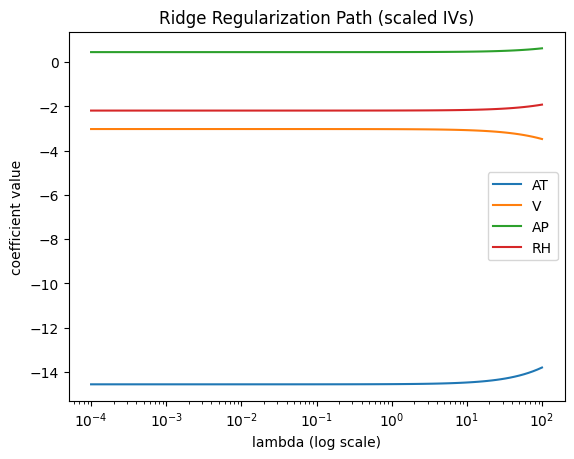

In [28]:
import matplotlib.pyplot as plt
plt.figure()
for j, name in enumerate(feature_names):
    plt.plot(lambdas, ridge_coefs[:, j], label=name)

plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("coefficient value")
plt.title("Ridge Regularization Path (scaled IVs)")
plt.legend()
plt.show()


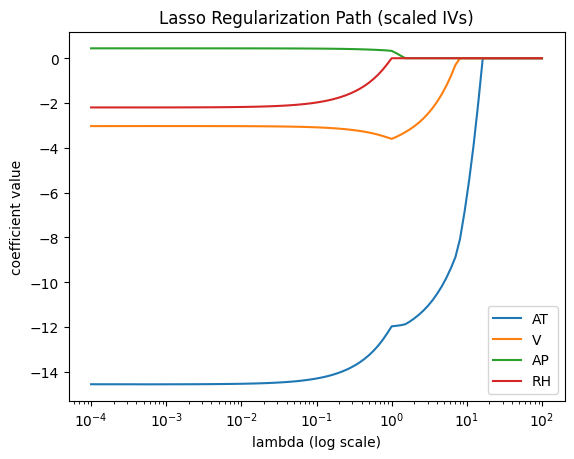

In [29]:
plt.figure()
for j, name in enumerate(feature_names):
    plt.plot(lambdas, lasso_coefs[:, j], label=name)

plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("coefficient value")
plt.title("Lasso Regularization Path (scaled IVs)")
plt.legend()
plt.show()


**Discussion**

**What happens to coefficients as λ increases in Ridge vs Lasso?**

In Ridge regression, coefficient magnitudes shrink smoothly toward zero as λ grows, but they never become exactly zero. All predictors remain in the model, with their influence gradually reduced.
In Lasso regression, coefficients also shrink as λ increases, but many coefficients reach exactly zero once λ is large enough. This produces a sparse model in which some features are completely removed.

**Which regression is better under multicollinearity in IVs, and why?**

Ridge regression is better under multicollinearity. When predictors are highly correlated, Ridge stabilizes the solution by shrinking correlated coefficients together rather than arbitrarily selecting one and discarding others. This reduces variance and leads to more stable and reliable coefficient estimates. Lasso, by contrast, may drop one correlated variable and keep another, making results less stable under strong multicollinearity.

**Which regression is better for feature selection, and why?**

Lasso regression is better for feature selection. Because the L1 penalty can drive coefficients exactly to zero, Lasso automatically performs variable selection by excluding less important predictors from the model. Ridge regression cannot do this because its coefficients remain nonzero, even for very large λ.